## Introduction
### Resources used
* For loading dataset in kaggle: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
* For exploring data and training the model, the code was adapted from this notebook: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

## Loading dataset from kaggle

In [19]:
!pip install kaggle

In [20]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [21]:
import getpass
print("Paste the content from kaggle.json, then press Enter:")
tokenString = getpass.getpass()
with open('/content/.kaggle/kaggle.json', 'w') as file:
  file.write(tokenString)

Paste the content from kaggle.json, then press Enter:
··········


In [22]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [24]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content/skin-cancer-data

 99% 321M/325M [00:03<00:00, 88.1MB/s]
100% 325M/325M [00:03<00:00, 92.2MB/s]


In [0]:
!cd skin-cancer-data; unzip *.zip

Archive:  skin-cancer-malignant-vs-benign.zip
  inflating: data/test/benign/1.jpg  
  inflating: data/test/benign/10.jpg  
  inflating: data/test/benign/1003.jpg  
  inflating: data/test/benign/1006.jpg  
  inflating: data/test/benign/1013.jpg  
  inflating: data/test/benign/1018.jpg  
  inflating: data/test/benign/1019.jpg  
  inflating: data/test/benign/1023.jpg  
  inflating: data/test/benign/1025.jpg  
  inflating: data/test/benign/1029.jpg  
  inflating: data/test/benign/1033.jpg  
  inflating: data/test/benign/1034.jpg  
  inflating: data/test/benign/1042.jpg  
  inflating: data/test/benign/1044.jpg  
  inflating: data/test/benign/105.jpg  
  inflating: data/test/benign/1055.jpg  
  inflating: data/test/benign/1061.jpg  
  inflating: data/test/benign/1070.jpg  
  inflating: data/test/benign/1074.jpg  
  inflating: data/test/benign/1077.jpg  
  inflating: data/test/benign/1080.jpg  
  inflating: data/test/benign/1087.jpg  
  inflating: data/test/benign/1088.jpg  
  inflating: data

In [0]:
!ls skin-cancer-data

data  skin-cancer-malignant-vs-benign.zip  test  train


## Exploring the data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
data = ImageDataBunch.from_folder("/content/skin-cancer-data")

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [0]:
!mv /content/skin-cancer-data/test /content/skin-cancer-data/valid

In [0]:
data = ImageDataBunch.from_folder("/content/skin-cancer-data")

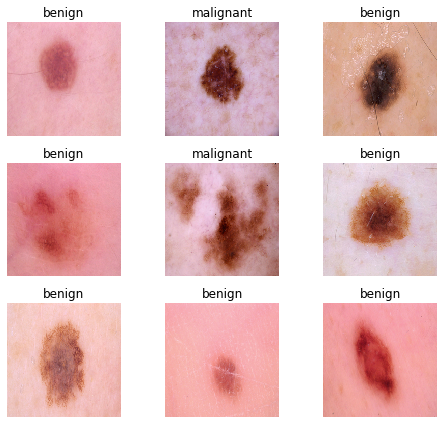

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)

['benign', 'malignant']


## Training: resnet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.4MB/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.800532,0.733625,0.221212,00:22
1,0.558697,0.398431,0.177273,00:20
2,0.390089,0.366515,0.154545,00:20
3,0.286571,0.356489,0.145455,00:20


In [0]:
learn.save('stage-1')


## Results

In [0]:

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

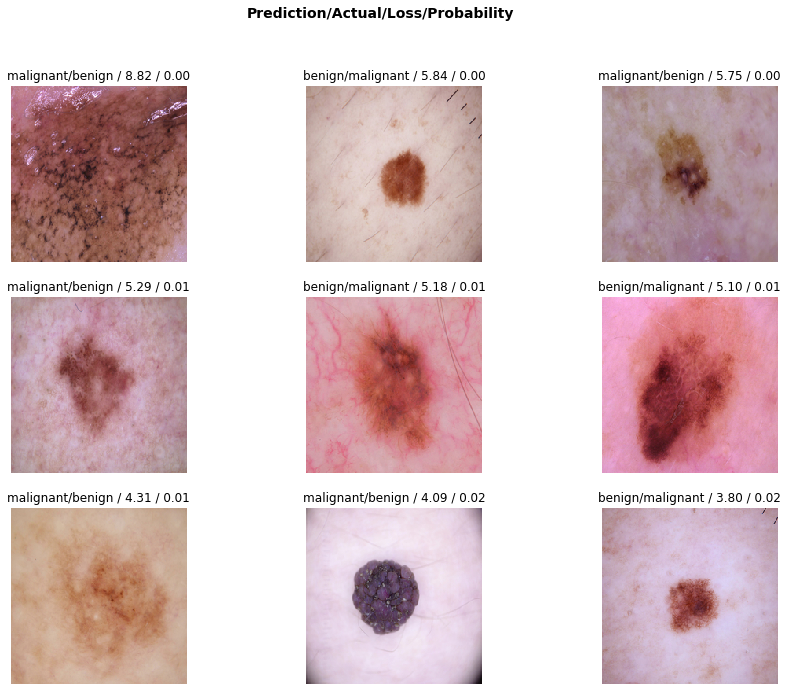

In [0]:
interp.plot_top_losses(9, figsize=(15,11))


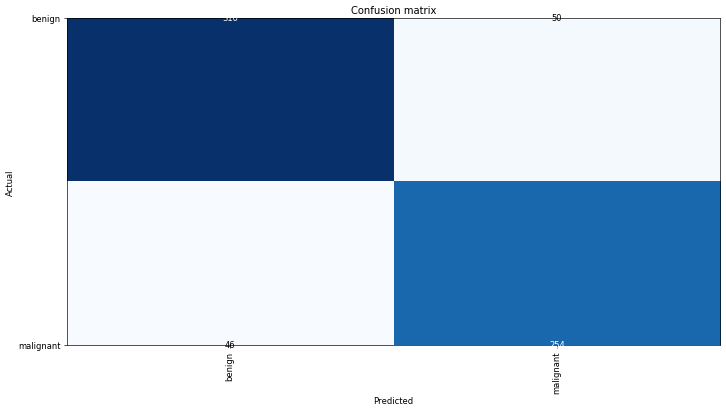

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Unfreezing, fine-tuning, and learning rates

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time
0,0.350733,0.315599,0.140909,00:29


In [0]:
learn.load('stage-1');
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


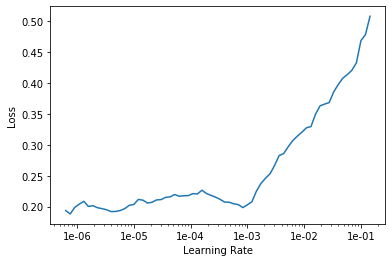

In [0]:
learn.recorder.plot()


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.222841,0.348106,0.143939,00:28
1,0.185499,0.337923,0.142424,00:29


In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.133819,0.344807,0.146970,00:28
1,0.113872,0.342218,0.142424,00:28


In [0]:
learn.save('stage-2');